# start

In [119]:
PRFX='mdl0331_1'
trntmstmp=1584412344
valtmstmp=1585761578

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_val_min,tm_val_max=(1581552000, 1582156799)

SEED=101

valsz = int(1e4)
trnsz = int(1e5)

train_total=int(1.5e8)
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, valtmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_val_min,tm_val_max)])

train_total 150,000,000, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-01 17:19:38']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [120]:
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_follower_cnt','u2_following_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
print(tgt2col)
ntgts=len(tgts)

{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [133]:
df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
display(df.twtid)
display(dfval.twtid)
display(dftrn.twtid)

0    D4D1EBDE74F74C5DA529959AF979625C
1    BFB529DAB6D384EB83E899A72AB3830D
2    519078C7834E9642508F72A6C2D0F3B7
3    52AAE9E33EFAC8C478C57B31A9E31ED1
4    89C1298C55EB3D68E2784F0BFB69E6F8
Name: twtid, dtype: object

0    D4D1EBDE74F74C5DA529959AF979625C
1    BFB529DAB6D384EB83E899A72AB3830D
Name: twtid, dtype: object

0    519078C7834E9642508F72A6C2D0F3B7
1    52AAE9E33EFAC8C478C57B31A9E31ED1
2    89C1298C55EB3D68E2784F0BFB69E6F8
Name: twtid, dtype: object

In [196]:
def prp_tm(df, col):
    dt=pd.to_datetime(df[col], unit='s')
    df[col+'_dayofweek']=dt.dt.dayofweek
    df[col+'_hour']=dt.dt.hour

def prpdf(df,istrn=True):
    tags = ['hshtgs','media','links','domns',]
    for tag in tags:
        df[f'has_{tag}']=df[tag].notna()
        df[tag]=df[tag].fillna('')
        lst=df[tag].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tag}']=lst.apply(len)

    df['toks']=df.toks.apply(lambda x: x.split('\t'))
    df['len_toks']=df.toks.apply(len)
    
    prp_tm(df, 'tm')
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm
    if istrn:
        df['tmleft_twt']   = tm_trn_max-df.tm
        df['tmleft_u1']    = tm_trn_max-df.u1_create_tm
        df['tmleft_u2']    = tm_trn_max-df.u2_create_tm
    else:
        df['tmleft_twt']   = tm_val_max-df.tm
        df['tmleft_u1']    = tm_val_max-df.u1_create_tm
        df['tmleft_u2']    = tm_val_max-df.u2_create_tm
    
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna()
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df    

In [197]:
%%time
dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz,nrows=trnsz)

CPU times: user 73.2 ms, sys: 11 ms, total: 84.2 ms
Wall time: 83 ms


In [198]:
%%time
dftrn = prpdf(dftrn)

CPU times: user 121 ms, sys: 4.07 ms, total: 125 ms
Wall time: 123 ms


In [200]:
cols_feat=[o for o in dftrn.columns if o not in cols_tgt]
cols_feat

['u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_follower_cnt',
 'u2_following_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'has_hshtgs',
 'n_hshtgs',
 'has_media',
 'n_media',
 'has_links',
 'n_links',
 'has_domns',
 'n_domns',
 'len_toks',
 'tm_dayofweek',
 'tm_hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'tmleft_twt',
 'tmleft_u1',
 'tmleft_u2']

In [201]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)

CPU times: user 17.3 ms, sys: 0 ns, total: 17.3 ms
Wall time: 14.3 ms


In [202]:
%%time
dfval = prpdf(dfval)

CPU times: user 45.3 ms, sys: 136 µs, total: 45.5 ms
Wall time: 40.3 ms


# model

In [203]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 1,
    'eval_metric': [ 'aucpr','logloss',],
} for k in tgts}
tgt2res = {}


In [204]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=5,#10, 
                    evals=evallist, evals_result=evals_result, 
                    verbose_eval=50,
                    early_stopping_rounds=10)
    return bst,evals_result

def valid(bst,dtr,dvl):
    prdtr = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    prdvl = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    return prdtr,prdvl


def traintgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    
    msk_vl=np.random.rand(len(dftrn))<0.15
    idxvl=np.where( msk_vl)[0]
    idxtr=np.where(~msk_vl)[0]
    ytr=dftrn.iloc[idxtr][tgtcol]
    yvl=dftrn.iloc[idxvl][tgtcol]
    dtr = xgb.DMatrix(dftrn.iloc[idxtr][cols_feat], label=ytr, feature_names=cols_feat)
    dvl = xgb.DMatrix(dftrn.iloc[idxvl][cols_feat], label=yvl, feature_names=cols_feat)
    bst,evals_result=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dtr,dvl)
    return {
    'bst':bst,
    'evals_result':evals_result,
    'ytr':ytr,
    'yvl':yvl,
    'prdtr':prdtr,
    'prdvl':prdvl,
    }
    

In [205]:
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    tgt2res[tgt]=traintgt(tgt)

2020-03-31 19:29:30 Retweet ********************************************************************************
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.27226	train-logloss:0.53453	eval-aucpr:0.14064	eval-logloss:0.53529
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[4]	train-aucpr:0.43718	train-logloss:0.33915	eval-aucpr:0.15211	eval-logloss:0.35338
2020-03-31 19:29:30 Reply ********************************************************************************
{'objective': 'binary:logistic', 'verbosity': 1, 'eval_metric': ['aucpr', 'logloss']}
[0]	train-aucpr:0.08578	train-logloss:0.46407	eval-aucpr:0.04016	eval-logloss:0.46436
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 10 rounds.
[4]	train-aucpr:0.28322	train-logloss:0.17341	eval-aucpr

# analyze

## tr vl

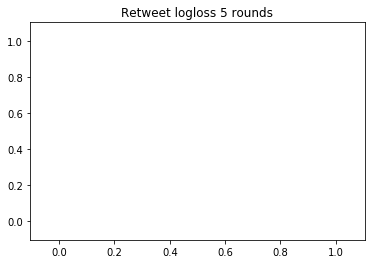

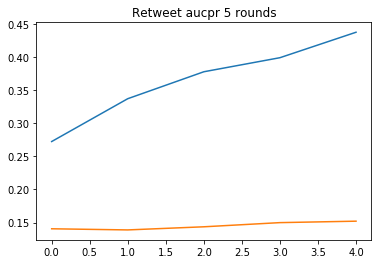

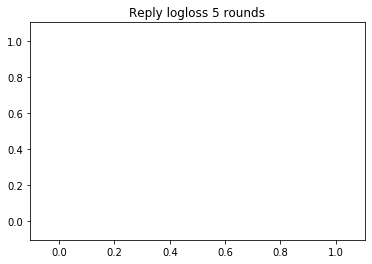

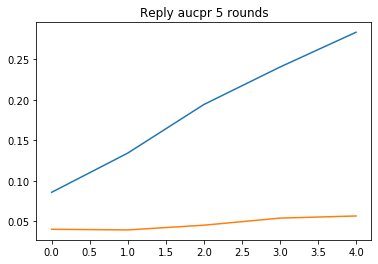

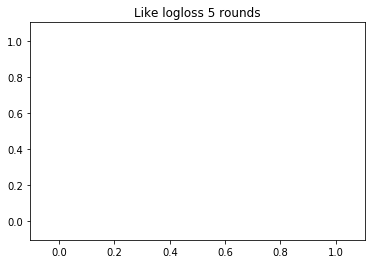

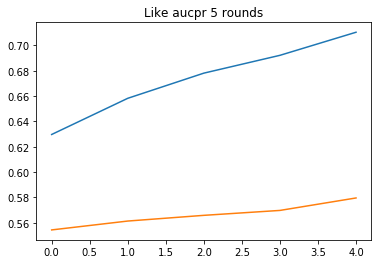

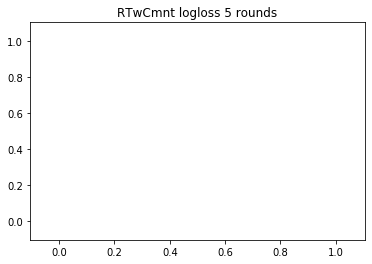

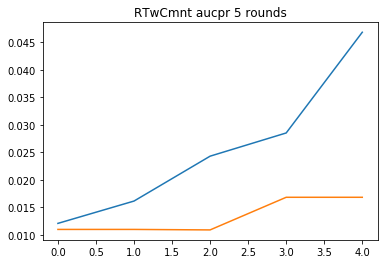

In [206]:
for tgt,res in tgt2res.items():
    evalres=res['evals_result']
    plt.plot(evalres['train']['logloss'][10:])
    plt.plot(evalres['eval']['logloss'][10:])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()

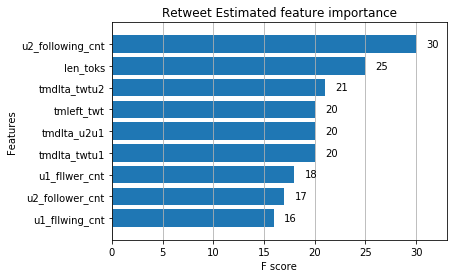

Retweet


,0,1
9,u2_following_cnt,30
3,len_toks,25
2,tmdlta_twtu2,21
1,tmdlta_twtu1,20
4,tmdlta_u2u1,20
13,tmleft_twt,20
6,u1_fllwer_cnt,18
0,u2_follower_cnt,17
7,u1_fllwing_cnt,16
10,tmleft_u2,13


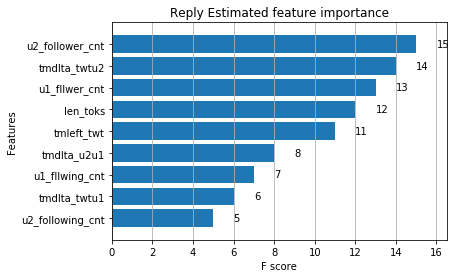

Reply


,0,1
9,u2_follower_cnt,15
2,tmdlta_twtu2,14
4,u1_fllwer_cnt,13
5,len_toks,12
6,tmleft_twt,11
7,tmdlta_u2u1,8
3,u1_fllwing_cnt,7
10,tmdlta_twtu1,6
0,tmleft_u2,5
8,u2_following_cnt,5


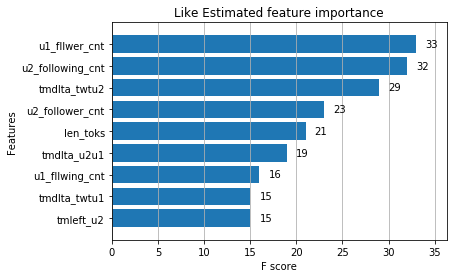

Like


,0,1
7,u1_fllwer_cnt,33
1,u2_following_cnt,32
5,tmdlta_twtu2,29
10,u2_follower_cnt,23
9,len_toks,21
3,tmdlta_u2u1,19
8,u1_fllwing_cnt,16
2,tmleft_u2,15
12,tmdlta_twtu1,15
16,tmleft_twt,14


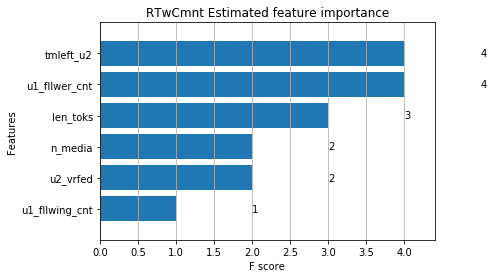

RTwCmnt


,0,1
0,u1_fllwer_cnt,4
1,tmleft_u2,4
2,len_toks,3
4,u2_vrfed,2
5,n_media,2
3,u1_fllwing_cnt,1


In [207]:
def show_feat_importance(tgt):
    bst=tgt2res[tgt]['bst']
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), 
                          feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgts:
    show_feat_importance(tgt)

In [212]:
tgt2res[tgt]

{'bst': <xgboost.core.Booster at 0x7feb88416190>,
 'evals_result': {'train': {'aucpr': [0.27226,
    0.336909,
    0.377566,
    0.39877,
    0.437178],
   'logloss': [0.534534, 0.446968, 0.394393, 0.362203, 0.339153]},
  'eval': {'aucpr': [0.140636, 0.13892, 0.143634, 0.14992, 0.152108],
   'logloss': [0.535291, 0.451639, 0.402351, 0.371544, 0.353384]}},
 'ytr': 0       False
 1       False
 2        True
 3        True
 5       False
         ...  
 9995    False
 9996    False
 9997    False
 9998    False
 9999    False
 Name: retwt, Length: 8488, dtype: bool,
 'yvl': 4       False
 12      False
 17      False
 18      False
 19      False
         ...  
 9945    False
 9950    False
 9965    False
 9974    False
 9980     True
 Name: retwt, Length: 1512, dtype: bool,
 'prdtr': array([0.22001795, 0.12251174, 0.18263867, ..., 0.16530588, 0.2162638 ,
        0.23152909], dtype=float32),
 'prdvl': array([0.1718434 , 0.24350673, 0.23305386, ..., 0.13674092, 0.17266318,
        0.21014

In [216]:
for tgt in tgts:
    res=tgt2res[tgt]
    print(tgt)
    prdtr, prdvl = res['prdtr'], res['prdvl']
    ytr, yvl = res['ytr'], res['yvl']
    auc_tr=compute_prauc(prdtr, ytr)
    rce_tr=compute_rce(prdtr, ytr)
    auc_vl=compute_prauc(prdvl, yvl)
    rce_vl=compute_rce(prdvl, yvl)
    res['scrs'] = {
        'auc_tr':auc_tr,
        'rce_tr':rce_tr,
        'auc_vl':auc_vl,
        'rce_vl':rce_vl,
    }    
    print('tr prauc:', f'{auc_tr:.4f}','tr rce:', f'{rce_tr:.4f}', )
    print('vl prauc:', f'{auc_vl:.4f}','vl rce:', f'{rce_vl:.4f}', )

Retweet
tr prauc: 0.4372 tr rce: 4.4983
vl prauc: 0.1517 vl rce: -5.9843
Reply
tr prauc: 0.2835 tr rce: -39.2597
vl prauc: 0.0567 vl rce: -47.6808
Like
tr prauc: 0.7104 tr rce: 10.7398
vl prauc: 0.5795 vl rce: 5.1301
RTwCmnt
tr prauc: 0.1032 tr rce: -188.4907
vl prauc: 0.0444 vl rce: -123.6885


In [217]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    res = tgt2res[tgt]
    if tgt not in tgt2res: continue
    lsttr+=[(f'PRAUC {tgt}',res['scrs']['auc_tr']),
          (f'RCE {tgt}',res['scrs']['rce_tr'])]
    lstvl+=[(f'PRAUC {tgt}',res['scrs']['auc_vl']),
          (f'RCE {tgt}',res['scrs']['rce_vl'])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.437198,4.4983,0.283538,-39.2597,0.710433,10.7398,0.103239,-188.491
scrvl,0.151731,-5.98426,0.0567297,-47.6808,0.579521,5.13008,0.0443554,-123.689


# infer

In [228]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)


CPU times: user 8.17 ms, sys: 12 µs, total: 8.18 ms
Wall time: 6.75 ms


In [230]:
%%time
dftst = prpdf(dftst, istrn=False)

CPU times: user 29.8 ms, sys: 8.85 ms, total: 38.7 ms
Wall time: 32.2 ms


In [233]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2res[tgt]['bst']
    prdtst = bst.predict(dtst, ntree_limit=bst.best_ntree_limit)
    tgt2prdtst[tgt] = prdtst

2020-03-31 19:38:43 Retweet
2020-03-31 19:38:43 Reply
2020-03-31 19:38:43 Like
2020-03-31 19:38:43 RTwCmnt
CPU times: user 238 ms, sys: 54.7 ms, total: 292 ms
Wall time: 23.4 ms


In [234]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [235]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-31 19:38:46 Retweet
2020-03-31 19:38:46 Reply
2020-03-31 19:38:46 RTwCmnt
2020-03-31 19:38:46 Like
CPU times: user 12.2 ms, sys: 14 µs, total: 12.2 ms
Wall time: 10.1 ms
